# Bhutan Rainfall EDA (ADM2 Level, 2021-2025)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
# Load the dataset
df = pd.read_csv("../data/btn-rainfall-adm2-5ytd.csv")
df.head()

,date,adm2_id,ADM2_PCODE,n_pixels,rfh,rfh_avg,r1h,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q,version
0,#date,#adm2+id,#adm2+code,#indicator+n_pixels+num,#indicator+rfh+num,#indicator+rfh_avg+num,#indicator+r1h+num,#indicator+r1h_avg+num,#indicator+r3h+num,#indicator+r3h_avg+num,#indicator+rfq+pct,#indicator+r1q+pct,#indicator+r3q+pct,#status
1,2021-01-01,5982,BT00702,2.0,1.5,1.7833,4.5,5.6333,35.5,51.9,95.8231,92.7505,73.5057,final
2,2021-01-11,5982,BT00702,2.0,1.5,1.6167,4.5,5.3167,29.5,33.7333,98.2368,94.6681,90.3201,final
3,2021-01-21,5982,BT00702,2.0,1.0,2.0,4.0,5.4,12.0,16.1833,85.7143,90.9091,84.0229,final
4,2021-02-01,5982,BT00702,2.0,1.5,2.3833,4.0,6.0,12.5,16.2,88.0361,87.5,85.8779,final


In [4]:
df = df.iloc[1:].copy() 

In [5]:
df.sample(3)

,date,adm2_id,ADM2_PCODE,n_pixels,rfh,rfh_avg,r1h,r1h_avg,r3h,r3h_avg,rfq,r1q,r3q,version
27671,2025-03-01,6115,BT01811,1.0,6.0,7.7333,14.0,18.7,26.0,37.3,86.3874,83.6237,76.1099,final
19135,2023-08-11,6020,BT01006,7.0,64.5714,61.0048,131.5714,150.8381,276.1429,351.9476,105.4037,88.0211,79.0564,final
16137,2024-10-11,6094,BT01509,1.0,17.0,18.5333,89.0,66.0333,246.0,264.8333,93.4844,130.206,93.1474,final


### Parse date and convert numerical column

In [6]:
df['date'] = pd.to_datetime(df['date'])
numeric_cols = ['n_pixels', 'rfh', 'rfh_avg', 'r1h', 'r1h_avg', 'r3h', 'r3h_avg', 'rfq', 'r1q', 'r3q']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

###  Add date components

In [7]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.month_name()
df['day'] = df['date'].dt.day


### Overview of data

In [8]:
print("Date Range:", df['date'].min(), "to", df['date'].max())
print("Unique ADM2 Regions:", df['ADM2_PCODE'].nunique())
print("Total Records:", len(df))
print("Missing Values:\n", df[numeric_cols].isnull().sum())
print("\nRainfall Summary Stats:\n", df[numeric_cols].describe())


Date Range: 2021-01-01 00:00:00 to 2025-06-01 00:00:00
Unique ADM2 Regions: 198
Total Records: 31680
Missing Values:
 n_pixels    0
rfh         0
rfh_avg     0
r1h         0
r1h_avg     0
r3h         0
r3h_avg     0
rfq         0
r1q         0
r3q         0
dtype: int64

Rainfall Summary Stats:
            n_pixels           rfh       rfh_avg           r1h       r1h_avg  \
count  31680.000000  31680.000000  31680.000000  31680.000000  31680.000000   
mean       7.126263     27.667664     31.827035     82.017228     94.242301   
std        8.738144     42.077771     40.997136    107.879000    119.594934   
min        1.000000      0.000000      0.000000      0.000000      0.086100   
25%        2.000000      2.333300      3.133300      8.500000     10.386700   
50%        4.000000     11.791300     16.053800     40.906150     47.838900   
75%        8.000000     35.200000     43.630000    111.500000    127.528600   
max       66.000000    434.000000    247.350000    849.500000    693.62

##  PART 1: EDA 

### Monthly rainfall trend

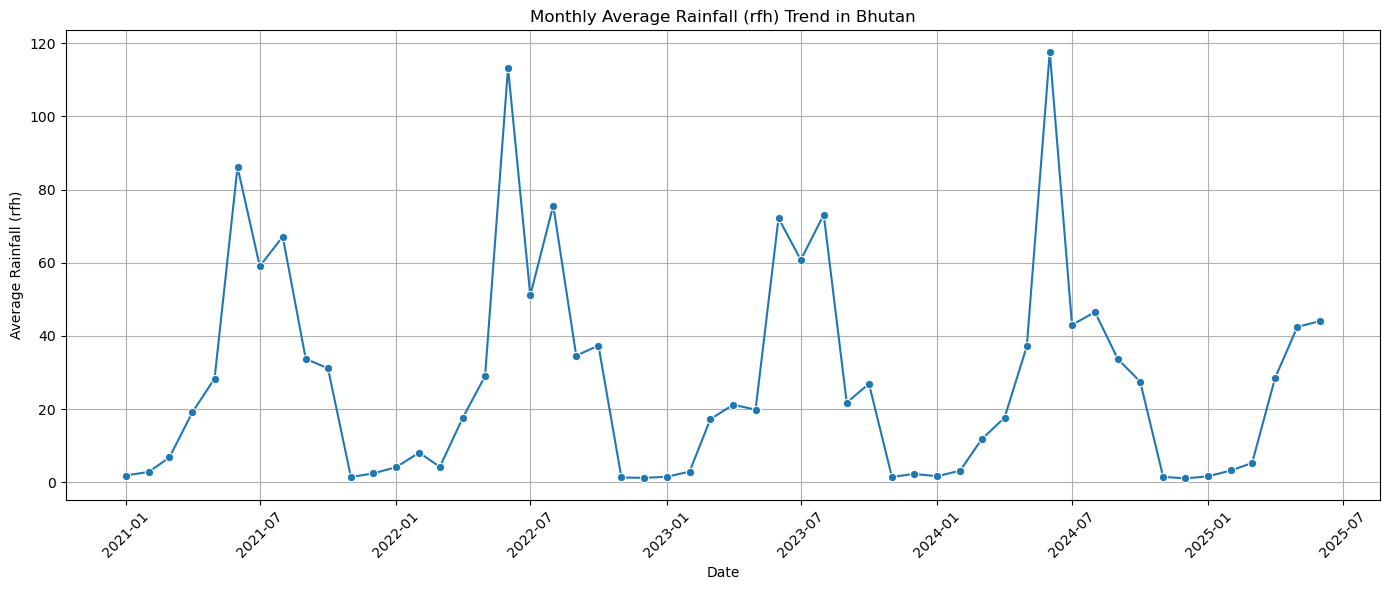

In [9]:
monthly_avg = df.groupby(['year', 'month'])['rfh'].mean().reset_index()
monthly_avg['date'] = pd.to_datetime(monthly_avg[['year', 'month']].assign(day=1))
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_avg, x='date', y='rfh', marker='o')
plt.title('Monthly Average Rainfall (rfh) Trend in Bhutan')
plt.xlabel('Date')
plt.ylabel('Average Rainfall (rfh)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../visuals/monthly_avg_rainfall.png')
plt.show()


**Monthly Rainfall Trend**
The chart above shows the average monthly rainfall (rfh) in Bhutan from 2021 to 2025. There is a clear seasonal pattern, with rainfall peaking during the summer monsoon months (June to August) and remaining low during the winter. This highlights the strong influence of monsoon on Bhutan's rainfall distribution, with significant inter-annual variability observed across the years.

## Boxplot by month

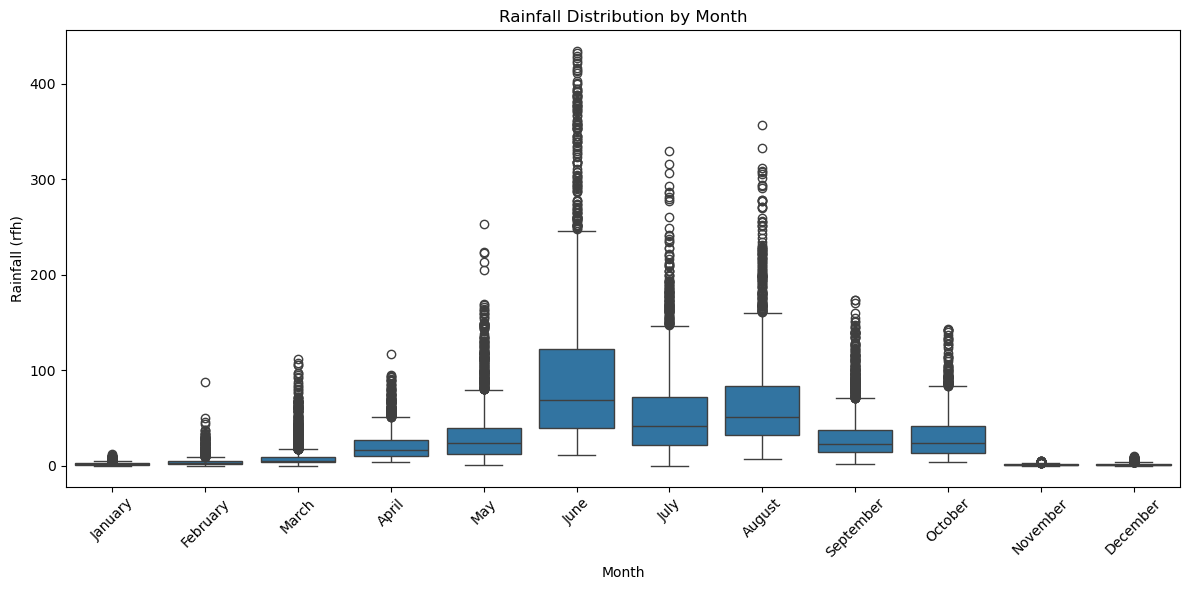

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='month_name', y='rfh', order=calendar.month_name[1:])
plt.title('Rainfall Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Rainfall (rfh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../visuals/rainfall_distribution_by_month.png')
plt.show()

The box plot  visualizes the distribution of daily rainfall (rfh) for each month across Bhutan. It highlights strong seasonality, with rainfall amounts peaking during the summer monsoon (June–August) and remaining low in the winter months. Outliers and the spread of the boxes show the variability and occasional extremes in monthly rainfall.

### Yearly total by top 10 regions

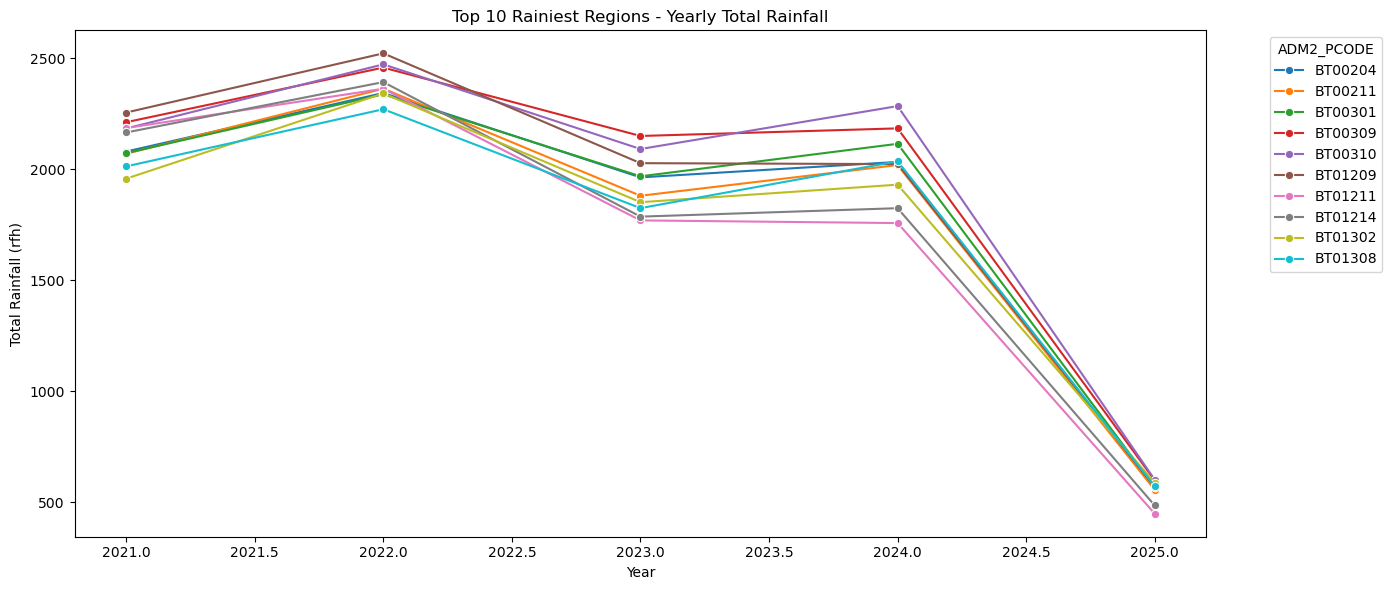

In [11]:
yearly_sum = df.groupby(['ADM2_PCODE', 'year'])['rfh'].sum().reset_index()
top10_regions = yearly_sum.groupby('ADM2_PCODE')['rfh'].sum().nlargest(10).index
top10_data = yearly_sum[yearly_sum['ADM2_PCODE'].isin(top10_regions)]
plt.figure(figsize=(14, 6))
sns.lineplot(data=top10_data, x='year', y='rfh', hue='ADM2_PCODE', marker='o')
plt.title('Top 10 Rainiest Regions - Yearly Total Rainfall')
plt.xlabel('Year')
plt.ylabel('Total Rainfall (rfh)')
plt.legend(title='ADM2_PCODE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../visuals/top10_rainiest_regions_yearly.png')
plt.show()

The line plot above displays the yearly total rainfall (rfh) for the ten regions in Bhutan with the highest cumulative rainfall from 2021 to 2025. Each line represents a region, allowing for comparison of rainfall trends across years.

**Result Analysis:**
- All top regions exhibit a pronounced drop in total rainfall in 2025, likely due to incomplete data for that year or a significant climatic anomaly.
- From 2021 to 2024, rainfall totals remain relatively consistent within each region, with some inter-annual variability.
- Regions such as BT00310, BT00309, and BT01209 consistently record the highest rainfall, indicating their exposure to the heaviest monsoon activity.
- The parallel movement of lines suggests that large-scale climatic factors (e.g., monsoon strength) impact all regions similarly, though local topography and microclimates may cause some divergence.
- This analysis highlights the spatial concentration of rainfall in certain regions, which is crucial for water resource management, flood risk assessment, and agricultural planning in Bhutan.

### Heatmap by region and year

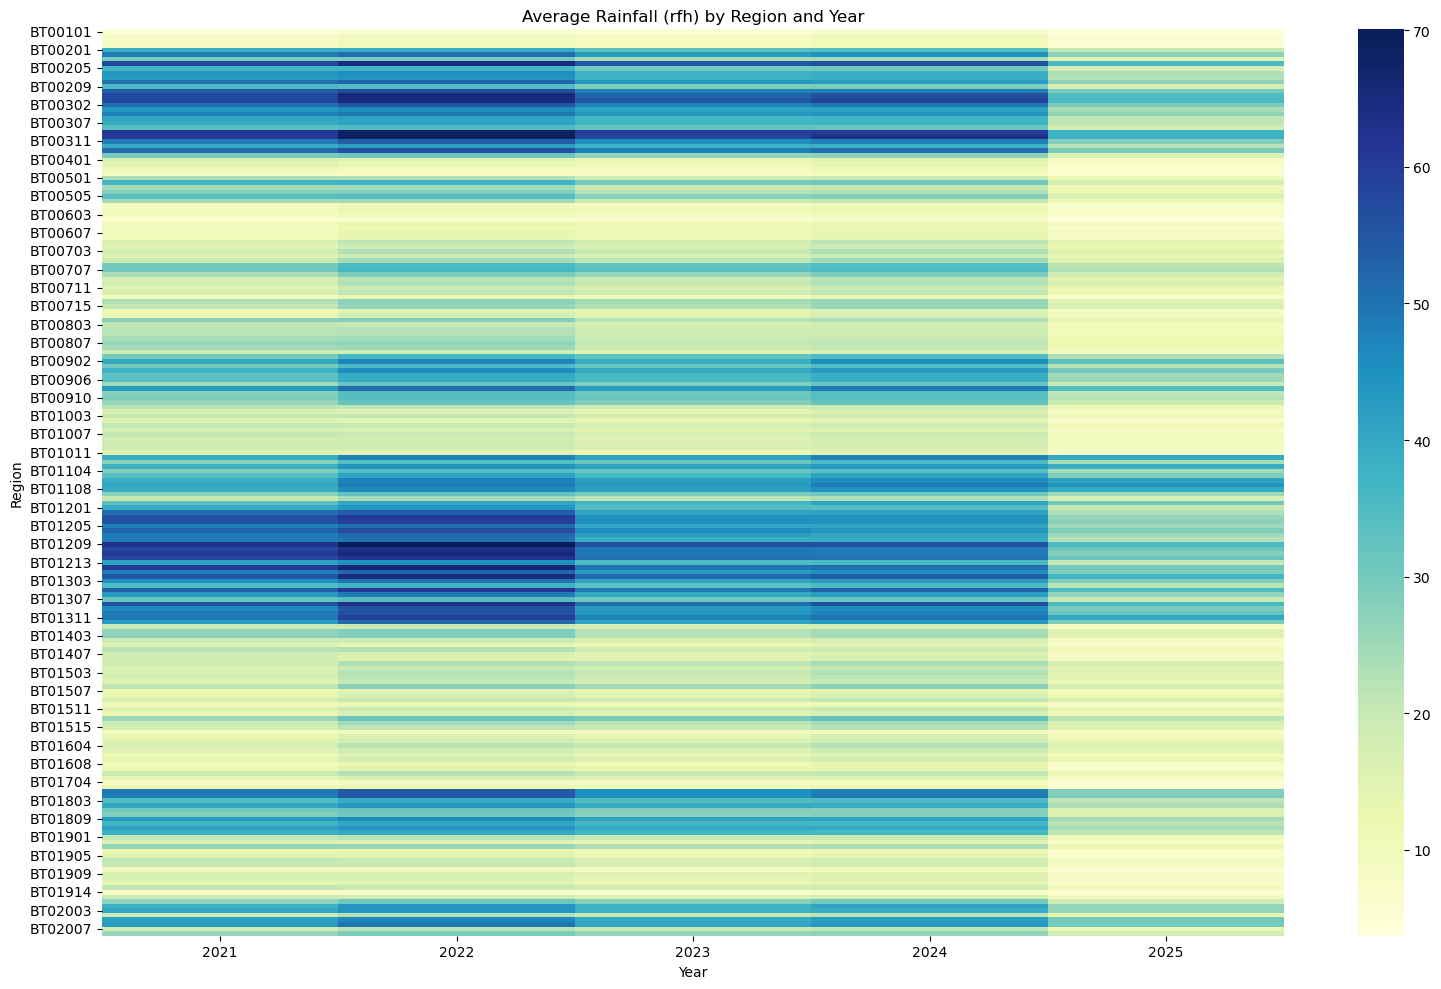

In [12]:
region_year_matrix = df.groupby(['ADM2_PCODE', 'year'])['rfh'].mean().unstack().fillna(0)
plt.figure(figsize=(16, 10))
sns.heatmap(region_year_matrix, cmap="YlGnBu")
plt.title("Average Rainfall (rfh) by Region and Year")
plt.xlabel("Year")
plt.ylabel("Region")
plt.tight_layout()
plt.savefig('../visuals/avg_rainfall_region_year_heatmap.png')
plt.show()

The heatmap above visualizes the average annual rainfall (rfh) across all ADM2 regions in Bhutan from 2021 to 2025. Each row represents a region, and each column corresponds to a year.

**Key Observations:**
- **Spatial Patterns:** Certain regions consistently receive higher average rainfall, as indicated by darker shades. These regions are likely located in areas more exposed to monsoon influences or orographic effects.
- **Temporal Trends:** Most regions show relatively stable rainfall patterns from 2021 to 2024, with a noticeable decrease in 2025. This drop is likely due to incomplete data for 2025 rather than a true climatic anomaly.
- **Regional Variability:** There is significant variation in rainfall between regions, highlighting the diverse microclimates within Bhutan. Some regions experience much higher rainfall than others, which is important for local water resource management and agricultural planning.
- **Consistency:** The parallel shading across years for many regions suggests that large-scale climatic drivers (such as the monsoon) impact the entire country in a similar way, though local factors modulate the magnitude.

**Implications:**  
Understanding these spatial and temporal rainfall patterns is crucial for disaster risk reduction, infrastructure planning, and sustainable development in Bhutan. Regions with persistently high rainfall may be more prone to flooding and landslides, while drier areas may face water scarcity challenges.

### Rainfall distribution Analysis

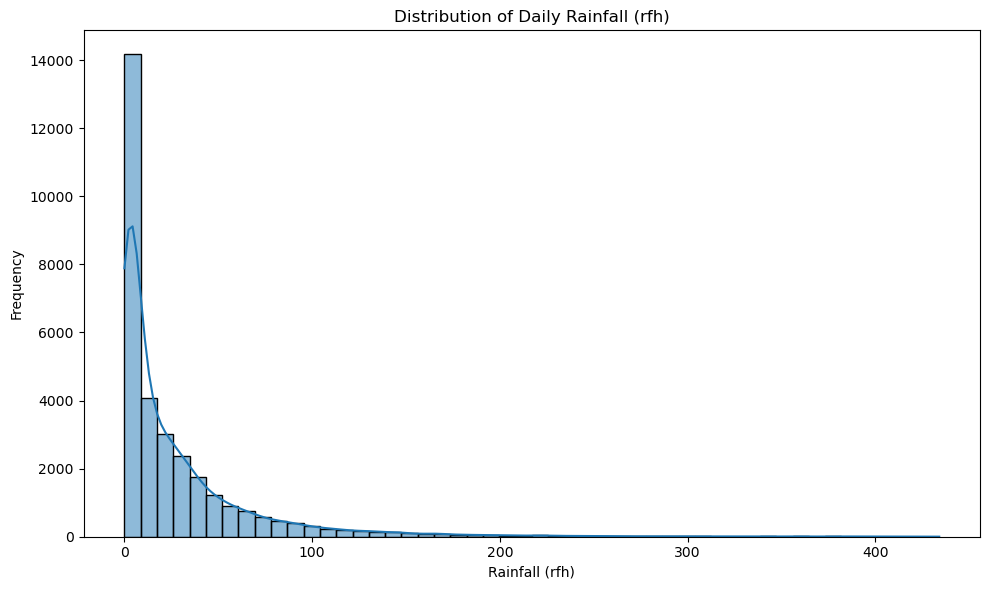

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df['rfh'], bins=50, kde=True)
plt.title('Distribution of Daily Rainfall (rfh)')
plt.xlabel('Rainfall (rfh)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('../visuals/rainfall_distribution_histogram.png')
plt.show()


The histogram above illustrates the distribution of daily rainfall (rfh) across Bhutan from 2021 to 2025. Most days experience low rainfall, with a long tail indicating occasional heavy rainfall events. This right-skewed pattern highlights the dominance of light rain days, punctuated by fewer but significant extreme rainfall occurrences—typical of monsoon-driven climates.

## PART 2: Trend Analysis and Seasonality

### National level time series decomposition

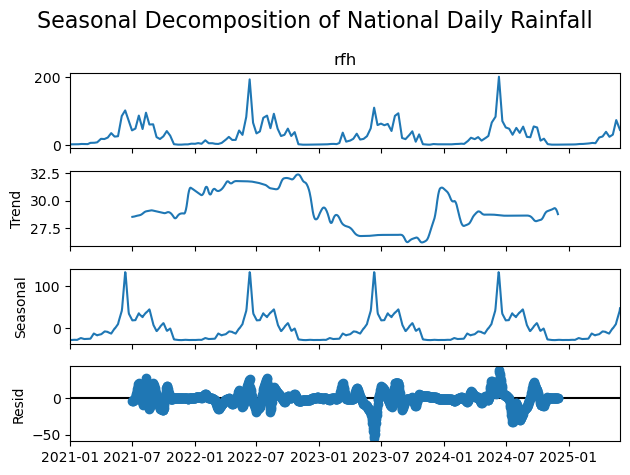

In [14]:
# National level time series decomposition
national_daily = df.groupby('date')['rfh'].mean().asfreq('D').interpolate()
decomp = seasonal_decompose(national_daily, model='additive', period=365)
decomp.plot()
plt.suptitle('Seasonal Decomposition of National Daily Rainfall', fontsize=16)
plt.tight_layout()
plt.savefig('../visuals/national_rainfall_decomposition.png')
plt.show()

The seasonal decomposition chart reveals a strong annual rainfall cycle in Bhutan, with clear peaks during the monsoon months and low rainfall in winter. The trend component shows some year-to-year variability, but the dominant pattern is the pronounced seasonality driven by the monsoon. This highlights the critical role of seasonal rains in Bhutan’s climate and water resources.


## PART 3: Regional Clustering

### Prepare data: average monthly rainfall by region

In [15]:
monthly_region = df.groupby(['ADM2_PCODE', 'month'])['rfh'].mean().unstack().fillna(0)
scaler = StandardScaler()
monthly_scaled = scaler.fit_transform(monthly_region)

### KMeans clustering 

In [16]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(monthly_scaled)
monthly_region['Cluster'] = clusters

c:\Users\sanga\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [17]:
#save the cluster summary
monthly_region.to_csv('../outputs/monthly_region_clusters.csv')


### Cluster Profile

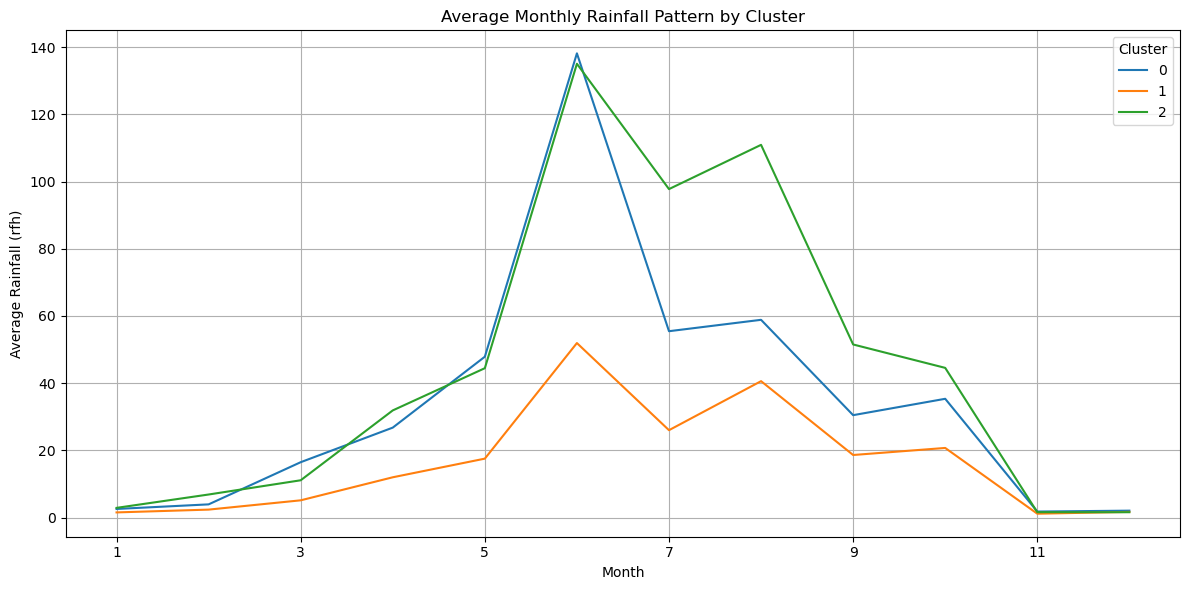

In [18]:
# Compute average monthly rainfall for each cluster
cluster_monthly_avg = monthly_region.groupby('Cluster').mean().T

# Plot
cluster_monthly_avg.plot(figsize=(12, 6))
plt.title("Average Monthly Rainfall Pattern by Cluster")
plt.xlabel("Month")
plt.ylabel("Average Rainfall (rfh)")
plt.grid(True)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()



The cluster profile plot reveals three distinct regional rainfall patterns in Bhutan:

- **Cluster 0:** Regions with the highest rainfall, peaking sharply during the monsoon (June–August).
- **Cluster 1:** Regions with consistently low rainfall throughout the year and a modest monsoon peak.
- **Cluster 2:** Regions with moderate rainfall and a pronounced but less extreme monsoon peak than Cluster 0.

These clusters highlight spatial differences in monsoon intensity and seasonality, useful for regional planning and risk assessment.

In [19]:
# Save cleaned dataframe for later modeling or mapping
df.to_csv("../data/cleaned_btn_rainfall.csv", index=False)